# train.csv
* 이게 뭔 놈인고 하니 그 유명한(?) 타이타닉 데이터입니다
* 타이타닉 탑승자들에 대한 데이터를 뽑아봅시다

* 컬럼 구성 : PassengerId, Survived, Pclass(선실 등급), Name, Sex, Age, SibSp(같이 탑승한 형제자매 배우자 수), Parch(같이 탑승한 부모님, 어린이 수), Ticket, Fare, Cabin(선실 번호), Embarked(경유지)
* Survived : 생존여부 (0 = 사망, 1 = 생존)
* 이 컬럼은 쓰지 않을 겁니다 : PassengerId, Name, SibSp, Parch, Ticket, Fare, Cabin
* 당연히 전처리부터 들어가야하는데 엑셀파일 보면 알겠지만 군데군데 결측치가 존재함 -> 평균값으로 대체합니다
* 문자열에 대한 인코딩도 잊지 말아주시고요 (label encoding을 이용하여 데이터프레임으로 출력)

* 생존률 구하기 과정
* pandas 라이브러리로 csv 가져오기 -> 필요한 컬럼만 남기고 drop 처리 -> fillna()를 이용한 결측치 처리
* -> LabelEncoder를 활용하여 인코딩 처리 수행
* 스케일링은 해보고 싶은 거로 하셔요
* 결측치 : Sex - 남자로 가정, Age - 평균, Embarked - S로 처리
* feature -> Sex, Age, Embarked // label -> Survived ::: 이렇게 구성해서 지도학습을 할 것이고

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder

In [2]:
# 일단 csv를 가져와서 불필요한 컬럼들을 버립시다

titanic_csv = pd.read_csv("./csv/train.csv")
titanic_df = titanic_csv.drop(columns=['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin'])
titanic_df

,Survived,Pclass,Sex,Age,Embarked
0,0,3,male,22.0,S
1,1,1,female,38.0,C
2,1,3,female,26.0,S
3,1,1,female,35.0,S
4,0,3,male,35.0,S
...,...,...,...,...,...
886,0,2,male,27.0,S
887,1,1,female,19.0,S
888,0,3,female,NaN,S
889,1,1,male,26.0,C


In [3]:
# 결측치를 확인해봅시다
titanic_df.isna().sum()
#titanic_df["Embarked"].value_counts()

# 나이는 평균으로 하고 정착지는 'S' 넣읍시다 (S가 압도적으로 많아서)

Survived      0
Pclass        0
Sex           0
Age         177
Embarked      2
dtype: int64

In [4]:
# 나이 결측치 & 정착지 결측치 채우기
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].mean()).round(0)
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')
titanic_df

,Survived,Pclass,Sex,Age,Embarked
0,0,3,male,22.0,S
1,1,1,female,38.0,C
2,1,3,female,26.0,S
3,1,1,female,35.0,S
4,0,3,male,35.0,S
...,...,...,...,...,...
886,0,2,male,27.0,S
887,1,1,female,19.0,S
888,0,3,female,30.0,S
889,1,1,male,26.0,C


In [5]:
# 나이대 구분을 해줘야 데이터 더 뽑을 것 같으니까
def age_group(x):
    if(x<=5): return "baby"
    elif(5<x<=13): return "child"
    elif(13<x<=19): return "teenager"
    elif(19<x<=39): return "young"
    elif(39<x<=65): return "elder"
    else: return "grand"

titanic_df["Age_group"] = titanic_df["Age"].apply(age_group)
titanic_df

,Survived,Pclass,Sex,Age,Embarked,Age_group
0,0,3,male,22.0,S,young
1,1,1,female,38.0,C,young
2,1,3,female,26.0,S,young
3,1,1,female,35.0,S,young
4,0,3,male,35.0,S,young
...,...,...,...,...,...,...
886,0,2,male,27.0,S,young
887,1,1,female,19.0,S,teenager
888,0,3,female,30.0,S,young
889,1,1,male,26.0,C,young


In [6]:
# 남녀 생존 데이터
titanic_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

In [7]:
# 남녀 생존 데이터에 연령대 끼얹어보자
titanic_df.groupby(['Sex','Age_group','Survived'])['Survived'].count()

Sex     Age_group  Survived
female  baby       0             5
                   1            16
        child      0             8
                   1             5
        elder      0            12
                   1            42
        teenager   0             9
                   1            32
        young      0            47
                   1           138
male    baby       0             8
                   1            15
        child      0             8
                   1             6
        elder      0            83
                   1            18
        grand      0             7
                   1             1
        teenager   0            47
                   1             5
        young      0           315
                   1            64
Name: Survived, dtype: int64

In [8]:
# 선실 등급별 생존 데이터
titanic_df.groupby(['Pclass','Survived'])['Survived'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

In [9]:
# 항구 별 생존 데이터 (근데 이건 의미가 있나?)
titanic_df.groupby(['Embarked','Survived'])['Survived'].count()

Embarked  Survived
C         0            75
          1            93
Q         0            47
          1            30
S         0           427
          1           219
Name: Survived, dtype: int64

In [10]:
# 연령대 별 생존 데이터
titanic_df.groupby(['Age_group','Survived'])['Survived'].count()

Age_group  Survived
baby       0            13
           1            31
child      0            16
           1            11
elder      0            95
           1            60
grand      0             7
           1             1
teenager   0            56
           1            37
young      0           362
           1           202
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Age_group', ylabel='Survived'>

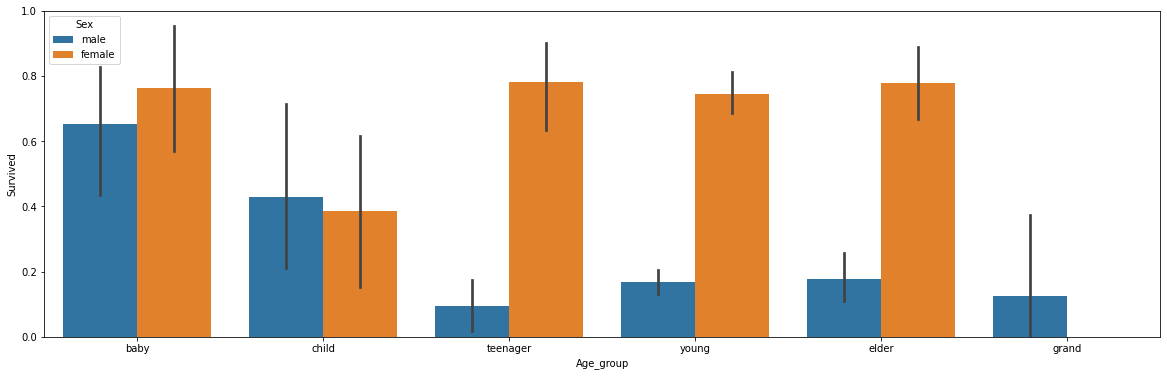

In [11]:
# 연령대 별 생존 그래프

plt.figure(figsize=(20,6))
group_names = ['baby','child','teenager','young','elder','grand']

sns.barplot(x='Age_group', y='Survived', hue='Sex', data=titanic_df, order=group_names)

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

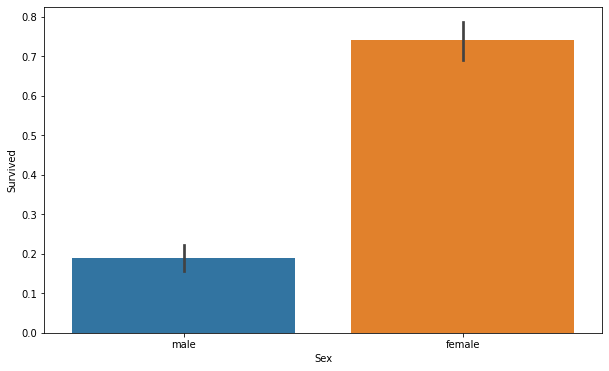

In [12]:
# 성별 생존 그래프

plt.figure(figsize=(10,6))
sns.barplot(x='Sex', y='Survived', data=titanic_df)

In [13]:
# feature -> Sex, Age, Embarked // label -> Survived ::: 이렇게 구성해서 지도학습을 할 것이고

from sklearn import preprocessing

titanic_learn = titanic_df.copy()

def encode_features(titanic_learn):
    features= ['Sex', 'Age', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(titanic_learn[feature])
        titanic_learn[feature] = le.transform(titanic_learn[feature])
    return titanic_learn

titanic_learn = encode_features(titanic_learn)
titanic_learn.info()
        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Survived   891 non-null    int64 
 1   Pclass     891 non-null    int64 
 2   Sex        891 non-null    int32 
 3   Age        891 non-null    int64 
 4   Embarked   891 non-null    int32 
 5   Age_group  891 non-null    object
dtypes: int32(2), int64(3), object(1)
memory usage: 34.9+ KB


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

y_titanic_learn = titanic_learn['Survived']
X_titanic_learn = titanic_learn.drop(['Survived', 'Age_group'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_learn, y_titanic_learn, test_size=0.2, random_state=11)

# DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=11)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTree 정확도: {0: .4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=11)
rf_clf.fit(X_train, y_train)
rf_fred = rf_clf.predict(X_test)
print('RandomForest 정확도: {0: .4f}'.format(accuracy_score(y_test, rf_fred)))

# LogisticRegressionClassifier
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_fred = lr_clf.predict(X_test)
print('LogisticRegression 정확도: {0: .4f}'.format(accuracy_score(y_test, lr_fred)))

DecisionTree 정확도:  0.8156
RandomForest 정확도:  0.8212
LogisticRegression 정확도:  0.8492


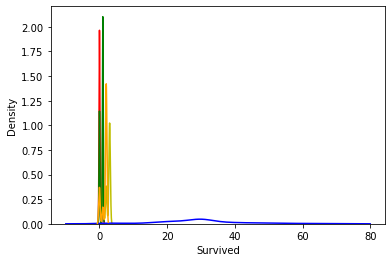

In [19]:
fig = plt.plot(figsize=(20,5))
sns.kdeplot(titanic_learn['Survived'], color = 'r')
sns.kdeplot(titanic_learn['Pclass'], color = 'y')
sns.kdeplot(titanic_learn['Sex'], color = 'g')
sns.kdeplot(titanic_learn['Age'], color = 'b')
sns.kdeplot(titanic_learn['Embarked'], color = 'orange')
plt.show()

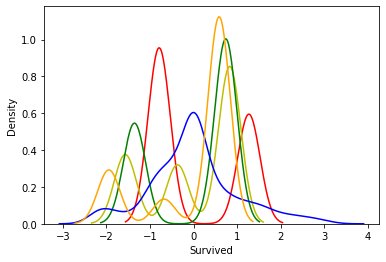

In [37]:
# Standard Scaler

titanic_scale = titanic_learn.drop(columns=['Age_group'])

sscaler = StandardScaler()
sscaler.fit(titanic_scale)
standard_df_t = sscaler.fit_transform(titanic_scale)
standard_df = pd.DataFrame(data=standard_df_t, columns=titanic_scale.columns)
standard_df

fig = plt.plot(figsize=(20,5))
sns.kdeplot(standard_df['Survived'], color = 'r')
sns.kdeplot(standard_df['Pclass'], color = 'y')
sns.kdeplot(standard_df['Sex'], color = 'g')
sns.kdeplot(standard_df['Age'], color = 'b')
sns.kdeplot(standard_df['Embarked'], color = 'orange')
plt.show()

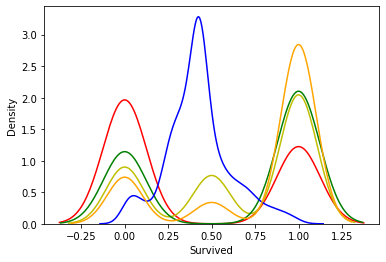

In [42]:
# Min-Max Scaler

mscaler = MinMaxScaler()
mscaler.fit(titanic_scale)

minmax_df = mscaler.fit_transform(titanic_scale)
minmax_df = pd.DataFrame(data=minmax_df, columns=titanic_scale.columns)
minmax_df

fig = plt.plot(figsize=(20,5))
sns.kdeplot(minmax_df['Survived'], color = 'r')
sns.kdeplot(minmax_df['Pclass'], color = 'y')
sns.kdeplot(minmax_df['Sex'], color = 'g')
sns.kdeplot(minmax_df['Age'], color = 'b')
sns.kdeplot(minmax_df['Embarked'], color = 'orange')
plt.show()

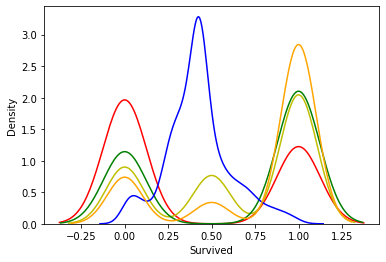

In [46]:
# Robust Scaling

rscaler = MinMaxScaler()
rscaler.fit(titanic_scale)

robust_df = rscaler.fit_transform(titanic_scale)
robust_df = pd.DataFrame(data=robust_df, columns=titanic_scale.columns)
robust_df

fig = plt.plot(figsize=(20,5))
sns.kdeplot(robust_df['Survived'], color = 'r')
sns.kdeplot(robust_df['Pclass'], color = 'y')
sns.kdeplot(robust_df['Sex'], color = 'g')
sns.kdeplot(robust_df['Age'], color = 'b')
sns.kdeplot(robust_df['Embarked'], color = 'orange')
plt.show()
